In [1]:
#Imports
import os
import collections
import operator
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
import visualization as v
import pickle

# Loading data from dataset

In [2]:
def load_data(train_path, test_path, dtype=np.float64, filename_sep='_'):
    """ Loads the data and labels from the dataset.

    Args:
        train_path (str): should contain different files with training data. Each file should contain 
                          data from different classes. The filename must include the class label (e.g. label.txt 
                          or label_1.txt).
        test_path (str): should contain the files with the test data. The same structure as in train_path applies
                         for the test directory.
        dtype (Numpy type, optional): Datatype of the data in the files. Defaults to np.float64.
        filename_sep (str, optional): special character after the label (i.e. '.' and '_' for the examples aforementioned).
                                      Defaults to '_'.

    Returns:
        Tuple[np.array, np.array, np.array, np.array, dict]: data and labels in the following order: train data, test data,
                                                             train ids, test ids. A dictionary to convert labels to ids.
    """
    X_train = None
    X_test = None
    y_train = None
    y_test = None
    label_to_id = {}
    id_to_label = {}

    for filename in os.listdir(train_path):
        label = filename.split(filename_sep)[0]

        if label not in label_to_id:
            label_to_id[label] = len(label_to_id.keys())
            id_to_label[label_to_id[label]] = label

        if X_train is None:
            X_train = np.fromfile(f'{train_path}/{filename}', dtype=dtype, sep='\n')
            y_train = np.ones((X_train.shape[0],)) * label_to_id[label]

        else:
            X_train = np.append(X_train, np.fromfile(f'{train_path}/{filename}', sep='\n'))
            y_train = np.append(y_train, np.ones((X_train.shape[0] - y_train.shape[0],)) * label_to_id[label])
    
    for filename in os.listdir(test_path):
        label = filename.split(filename_sep)[0]

        if X_test is None:
            X_test = np.fromfile(f'{test_path}/{filename}', dtype=dtype, sep='\n')
            y_test = np.ones((X_test.shape[0],)) * label_to_id[label]

        else:
            X_test = np.append(X_test, np.fromfile(f'{test_path}/{filename}', sep='\n'))
            y_test = np.append(y_test, np.ones((X_test.shape[0] - y_test.shape[0],)) * label_to_id[label])

    return X_train, X_test, y_train, y_test, label_to_id, id_to_label

# Compute the conditional probabilities

We are going to find the posterior probability of a set of states $\mathcal{X}$ belonging to one class $y$ (i.e., $P(y \mid \mathcal{X})$) through the naive condition of the bayes theorem:

$
P(y \mid \mathcal{X}) \propto p(\mathcal{X}|y) \cdot p(y) = p(x_1, \dots , x_n | y) \cdot p(y)
$

We will consider that the different states are *iid* (i.e., independent and identically distributed). Hence, the likelihood factorises as following:

$
p(y \mid \mathcal{X}) \propto  p(y) \cdot \prod^N_{i=1} P(x_i \mid y)
$

Therefore, for each class we need to compute the conditional probabilities of each state (i.e., $P(x_i \mid y)$).

At inference time (i.e., test time) the classifier is likely to find unseen states whose probability $P(x_i \mid y)$ is going to be 0. When facing these states, the posterior probability is determined to be 0, regardless the other states. To face this issue, we are going to apply Laplace smoothing (i.e., additive smoothing) to the conditional probabilities:

$
P(x_i \mid y) = \frac{C(x_i, y) + 1}{C(y) + V}
$

Where $C(x_i, y)$ are the counts of observations of the state $x_i$ for the class $y$, $C(y)$ are the number of states for class $y$ and $V$ is the number of different states (including the unseen). 

To avoid underflow problems and compute the probabilities in a more efficient way, we will work with the log transformation of the likelihoods:

$
p(y \mid \mathcal{X}) \propto  \log(p(y)) + \sum^N_{i=1} \log(P(x_i \mid y))
$

In [3]:
def get_conditional_prob(X_train, y_train, X_test):
    labels = np.unique(y_train)
    states = np.unique(X_train)
    unseen_states = np.setdiff1d(X_test, X_train)
    states = np.append(states, unseen_states)
    V = states.shape[0]
    
    conditional_prob = np.zeros((labels.shape[0], states.shape[0]))

    for i, y in enumerate(labels):
        states_y, C_states_y = np.unique(X_train[y_train==y], return_counts=True)
        C_y = states_y.shape[0]
        conditional_prob[i] += np.log(1/(C_y + V))

        # Get the indices in states that contain the values of states_y
        state_indices = np.nonzero(states_y[:,None] == states)[1]

        # Set the smoothed log-likelihood of each state
        conditional_prob[i][state_indices] = np.log((C_states_y + 1)/(C_y + V))
    
    return conditional_prob, states

We will use the conditional probabilities matrix $A \in \mathbb{R}^{MxV}$ (where M is the number of classes and V the number of different states) as a look-up table, which will give us the conditional probabilities for a particular state. 

To compute the probabilities of a particular state belonging to a certain class, we are going to convert the vector with the different test states $T \in \mathbb{R}^{N}$ (where N is the number of test states) into a matrix $B \in \mathbb{R}^{NxV}$ where each row represents a hot vector that selects the corresponding state in the conditional probabilities matrix $A$. 

Consider the following example, where we have the following conditional probabilities matrix A, when working with a dataset that contains 6 classes and 11 different states:

$
A = \begin{bmatrix}
-2.5649 & -1.8718 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -1.8718 \\
-2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -2.5649 & -1.8718 & -2.5649 & -1.8718 & -2.5649 \\
-1.9459 & -2.6390 & -2.6390 & -1.9459 & -2.6390 & -2.6390 & -1.9459 & -2.6390 & -2.6390 & -2.6390 & -2.6390 \\
-2.4849 & -2.4849 & -1.7917 & -2.4849 & -2.4849 & -2.4849 & -2.4849 & -2.4849 & -2.4849 & -2.4849 & -2.4849 \\
-2.4849 & -2.4849 & -2.4849 & -2.4849 & -2.4849 & -1.7917 & -2.4849 & -2.4849 & -2.4849 & -2.4849 & -2.4849 \\
-2.5649 & -2.5649 & -2.5649 & -2.5649 & -1.8718 & -2.5649 & -2.5649 & -2.5649 & -1.8718 & -2.5649 & -2.5649
\end{bmatrix}
$

For the sake of the example, assume that the state corresponds the number of the column in the $A$ matrix that contains the conditional log-probability for that state. Consider now the following test vector $T \in \mathbb{R}^{N}$:
$
T = \begin{bmatrix}
3\\
2\\ 
5 
\end{bmatrix}
$

Then the matrix $B$ that contains the hot vectors, will be the following:
$
B = \begin{bmatrix}
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$

And we can get the conditional log-probabilities ($P \in \mathbb{R}^{MxN}$) as follows:
$
P = A B^T = \begin{bmatrix}
-2.5649 & -1.8718 & -2.5649 \\
-2.5649 & -2.5649 & -2.5649 \\
-2.6390 & -2.6390 & -2.6390 \\
-1.7917 & -2.4849 & -2.4829 \\
-2.4849 & -2.4849 & -1.7917 \\
-2.5649 & -2.5649 & -2.5649 \\
\end{bmatrix}
$

Where each element of the matrix $P_{ij}$ will contain the log-probability of the state $j$ belonging to the class $i$.

Given the $P$ matrix, the log-probability of the test states belonging to each figure will correspond to the sum of the values of each row. The row with maximum sum will be the one that corresponds to the most likely class.



In [4]:
def get_hot_vector(states, test_states):
    hot_vector = np.zeros((test_states.shape[0], states.shape[0]))

    # Get the indices in states that contain the values of test_states
    state_indices = np.nonzero(test_states[:,None] == states)[1]
    
    # Set the smoothed log-likelihood of each state
    hot_vector[np.arange(len(state_indices)),state_indices] = 1
    return hot_vector
    
def naive_bayes_classifier(conditional_prob, states, X_test, return_prob=False):
    hot_v_states = get_hot_vector(states, X_test)
    prob = conditional_prob @ hot_v_states.T

    # sum(log(P(x_i|y)))
    posterior_prob = prob.sum(axis = 1)
    
    if return_prob:
        return np.argmax(posterior_prob), prob
    else:
        return np.argmax(posterior_prob)

def naive_bayes_classifier_lite(conditional_prob, start, end):
    posterior_prob = conditional_prob[:,start:end].sum(axis = 1)
    return np.argmax(posterior_prob)

# Evaluation

## Accuracy over time (i.e., considering more samples)

Testing different classes:   0%|          | 0/6 [00:00<?, ?class/s]

Testing different batch lengths:   0%|          | 0/300 [00:00<?, ?length/s]

Testing different batch lengths:   0%|          | 0/300 [00:00<?, ?length/s]

Testing different batch lengths:   0%|          | 0/300 [00:00<?, ?length/s]

Testing different batch lengths:   0%|          | 0/300 [00:00<?, ?length/s]

Testing different batch lengths:   0%|          | 0/300 [00:00<?, ?length/s]

Testing different batch lengths:   0%|          | 0/300 [00:00<?, ?length/s]

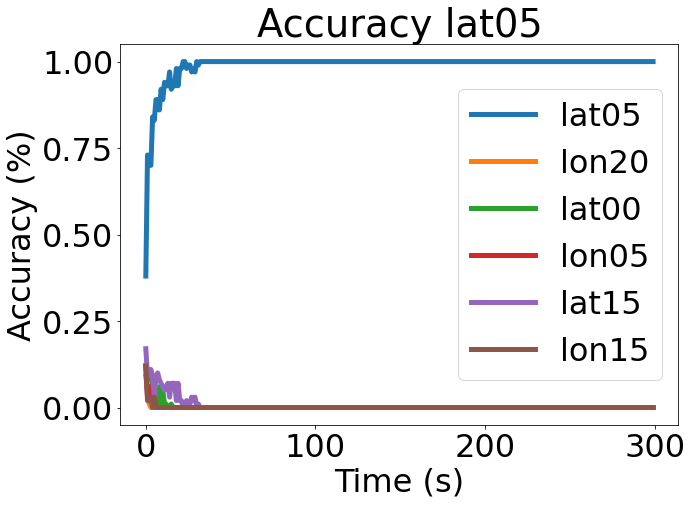

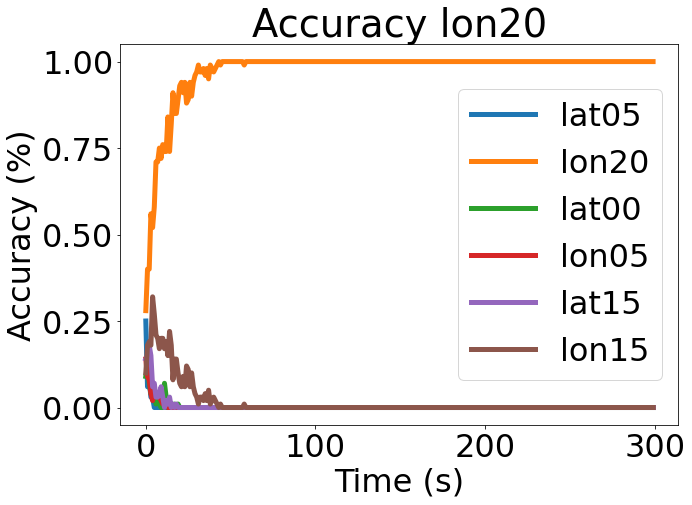

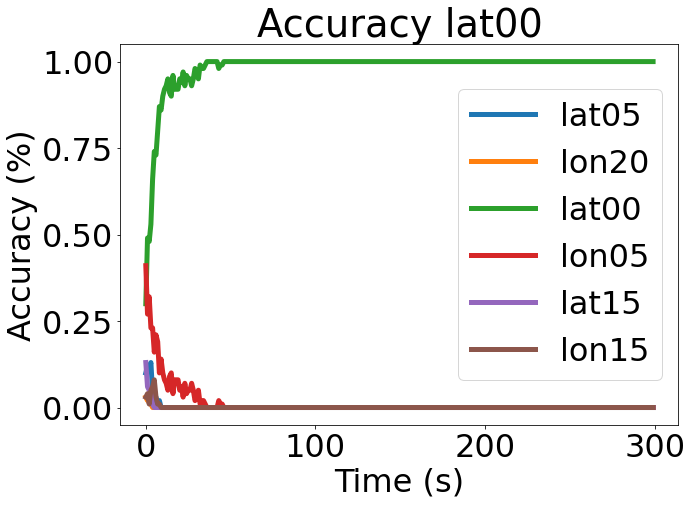

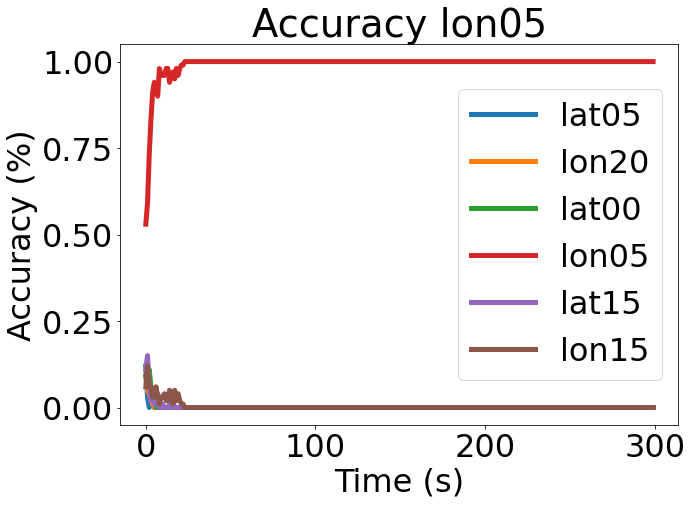

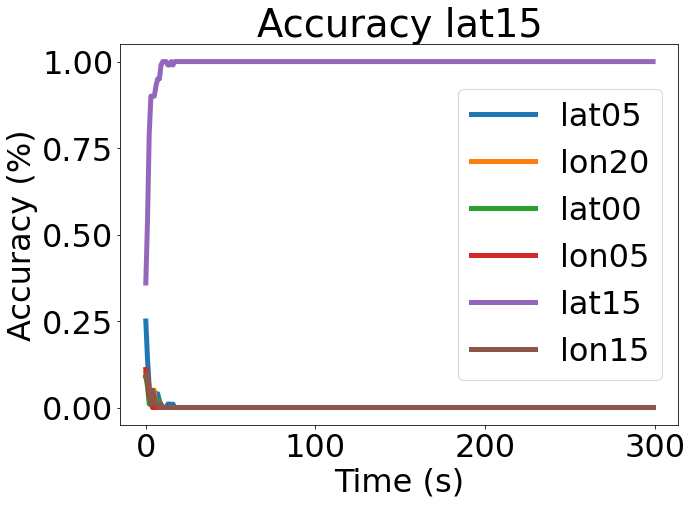

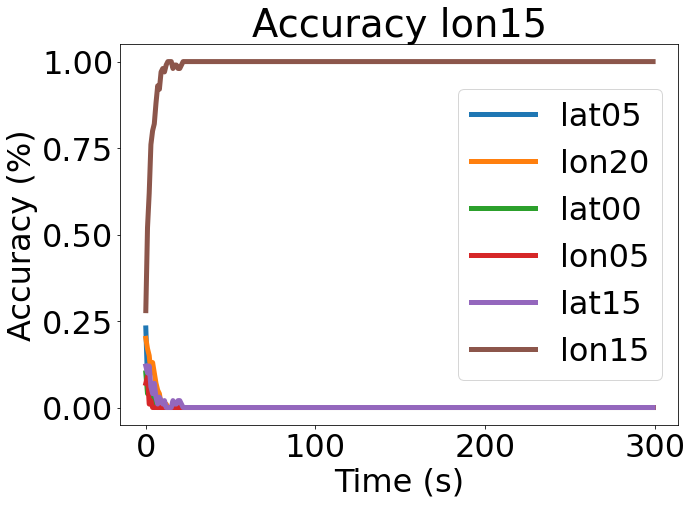

In [5]:
def accuracy_over_time(conditional_prob, states, X_test, y_test, n_start=1, n_end=12000, n_step=40, n_tests=100, sampling_rate=40):
    labels, counts = np.unique(y_test, return_counts=True)
    start = min(min(counts), n_start)
    end = min(min(counts), n_end)

    classifications = dict()
    hot_v_states = get_hot_vector(states, X_test)
    prob = conditional_prob @ hot_v_states.T
    
    for y in tqdm(labels, unit="class", desc="Testing different classes"):
        classifications[y] = None
        x_ticks = []

        for n in tqdm(range(start, end, n_step), unit="length", desc="Testing different batch lengths", leave=False):
            classifications[y] = np.zeros((len(labels), 1)) \
                                    if classifications[y] is None \
                                    else np.append(classifications[y], np.zeros((len(labels), 1)), axis=1)
            x_ticks.append(n/sampling_rate)

            i_tests = np.random.choice(min(counts)-n, n_tests)
            for i in i_tests:
                pred = naive_bayes_classifier_lite(prob[:,y_test == y], i, i+n)
                classifications[y][pred][-1] += 1
                
            classifications[y][:,-1] /= sum(classifications[y][:,-1])
    
    return classifications, x_ticks



X_train, X_test, y_train, y_test, label_to_id, id_to_label = load_data("./datasets/haptic_train", "./datasets/haptic_test")
conditional_prob, states = get_conditional_prob(X_train, y_train, X_test) # Kind of training
classifications, x_ticks = accuracy_over_time(conditional_prob, states, X_test, y_test)
pickle.dump(classifications, open('out/classifications/classifications_over_time.pkl', 'wb'))
pickle.dump(x_ticks, open('out/classifications/x_ticks.pkl', 'wb'))
pickle.dump(label_to_id, open('out/classifications/label_to_id.pkl', 'wb'))
pickle.dump(id_to_label, open('out/classifications/id_to_label.pkl', 'wb'))
v.plot_accuracy_over_time(classifications, id_to_label, x_ticks)


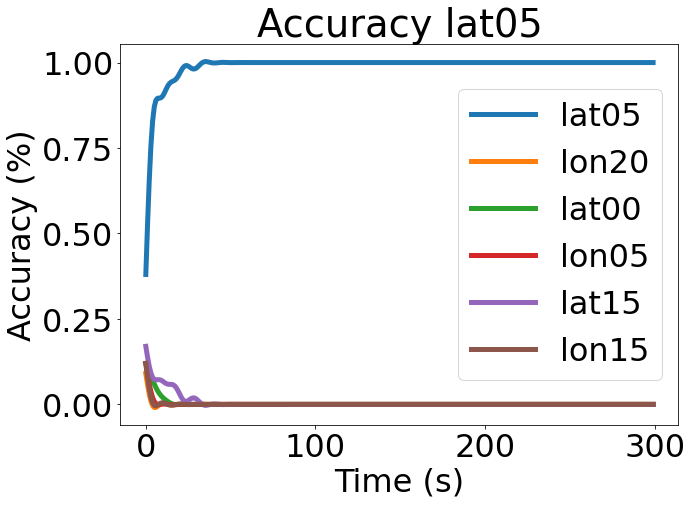

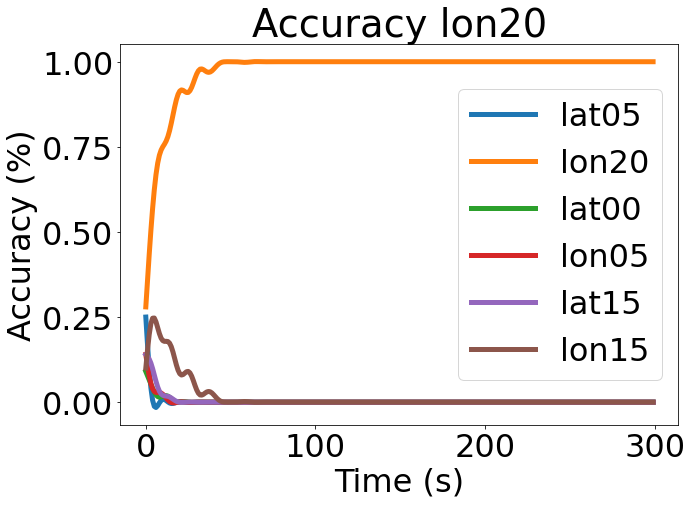

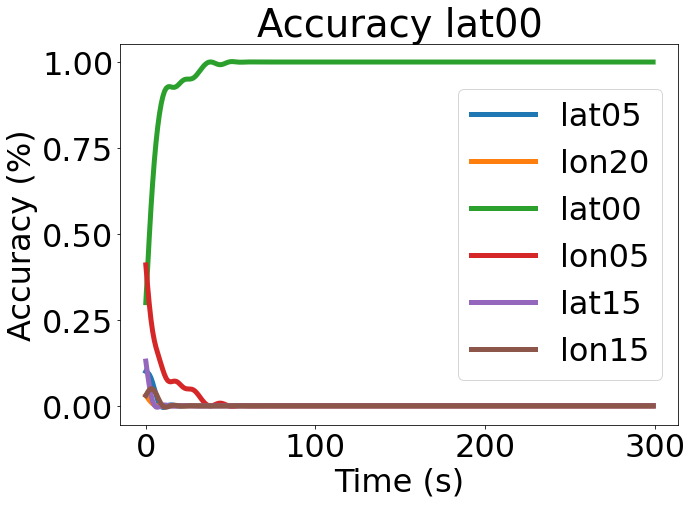

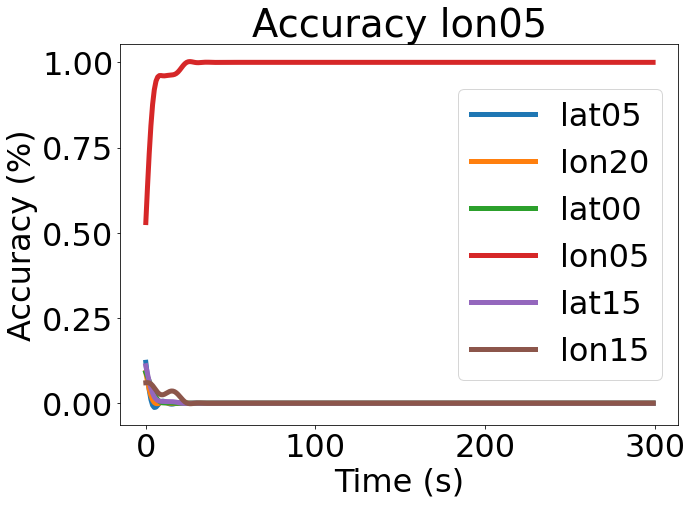

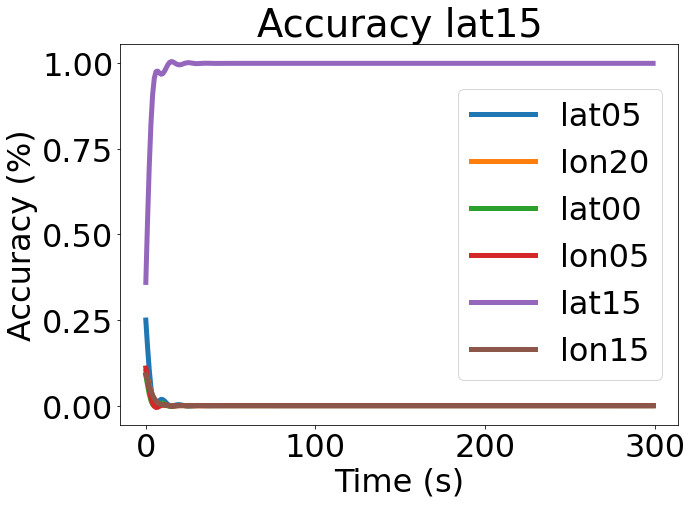

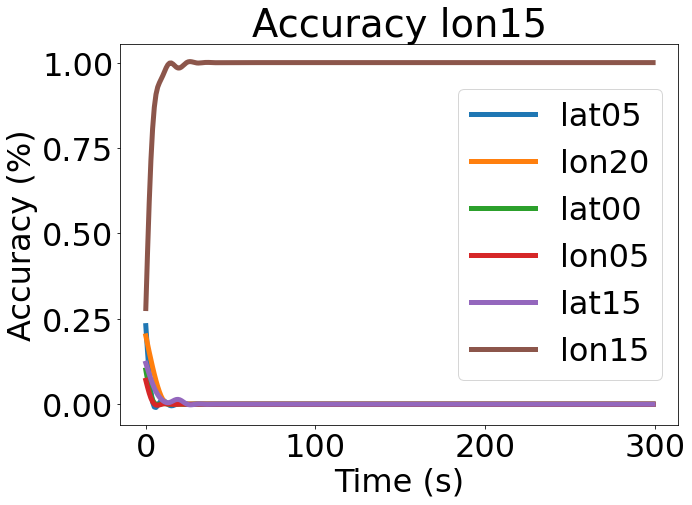

In [7]:
v.plot_accuracy_over_time(classifications, id_to_label, x_ticks, filtered=True)

## Confusion matrix

Testing different classes:   0%|          | 0/6 [00:00<?, ?class/s]

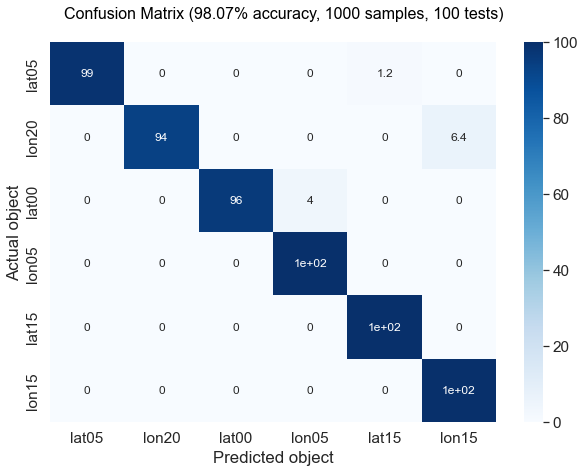

In [9]:
def get_confusion_matrix(conditional_prob, states, X_test, y_test, n_samples=1000, n_tests=1000):
    labels, counts = np.unique(y_test, return_counts=True)

    confusion_matrix = np.zeros((len(labels), len(labels)))
    hot_v_states = get_hot_vector(states, X_test)
    prob = conditional_prob @ hot_v_states.T

    for y in tqdm(labels, unit="class", desc="Testing different classes"):
        i_tests = np.random.choice(min(counts)-n_samples, n_tests)
        for i in i_tests:
            pred = naive_bayes_classifier_lite(prob[:,y_test == y], i, i+n_samples)
            confusion_matrix[int(y), pred] += 1

        confusion_matrix[int(y)] *= 100.0 / sum(confusion_matrix[int(y)])
    
    return confusion_matrix

X_train, X_test, y_train, y_test, label_to_id, id_to_label = load_data("./datasets/haptic_train", "./datasets/haptic_test")
conditional_prob, states = get_conditional_prob(X_train, y_train, X_test) # Kind of training
confusion_matrix = get_confusion_matrix(conditional_prob, states, X_test, y_test)
v.plot_confusion_matrix(confusion_matrix, id_to_label)

# Classification per sample

In [10]:
def classification_per_sample(conditional_prob, states, X_test):
    hot_v_states = get_hot_vector(states, X_test)
    prob = conditional_prob @ hot_v_states.T
    cumprob = np.cumsum(prob, axis=1)
    classifications = np.argmax(cumprob, axis=0)
    return classifications

X_train, X_test, y_train, y_test, label_to_id, id_to_label = load_data("./datasets/haptic_train", "./datasets/haptic_test")
conditional_prob, states = get_conditional_prob(X_train, y_train, X_test) # Kind of training

labels, counts = np.unique(y_test, return_counts=True)
for y in labels:
    classifications = classification_per_sample(conditional_prob, states, X_test[y_test == y])
    classifications = classifications.astype(int)
    label = id_to_label[y]
    with open(f'out/classifications/classification_per_sample/{label}.txt', 'w') as f:
        for pred in classifications:
            f.write(f'{id_to_label[pred]}\n')

classifications = classification_per_sample(conditional_prob, states, X_test)
with open('out/classifications/classification_per_sample.npy', 'wb') as f:
    np.save(f, classifications)